In [18]:
#please run roscore on terminal


In [19]:
#please run gazebo world on terminal


In [20]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers
from tensorflow.keras import Model
import numpy as np
import gym
import argparse
import logging
from datetime import datetime
import gc
gc.enable()
import rospy
import roslib
import rospy
import rostopic
import random
import time
import math
import csv
from std_srvs.srv import Empty
from gazebo_msgs.srv import SetModelConfiguration
from control_msgs.msg import JointControllerState
from sensor_msgs.msg import JointState
from gazebo_msgs.msg import LinkStates
from gazebo_msgs.msg import ContactsState
from geometry_msgs.msg import Pose
from std_msgs.msg import Float64
from std_msgs.msg import String
from sensor_msgs.msg import Joy
from gazebo_msgs.srv import DeleteModel
from gazebo_msgs.srv import SpawnModel
from controller_manager_msgs.srv import LoadController
from controller_manager_msgs.srv import SwitchController

import threading
from scipy.interpolate import interp1d

gpu_available = tf.test.is_gpu_available()

2021-11-03 04:36:18.687657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 04:36:18.688042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 04:36:18.688306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 04:36:18.688578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 04:36:18.688804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [21]:
ENV_NAME = 'BipedalWalker-UTHAI'
EPISODES = 500000
TEST = 10

In [22]:
LAP = rospy.Publisher(
        'uthai/l_ankle_pitch_position/command', Float64, queue_size=10)
LAR = rospy.Publisher(
    'uthai/l_ankle_roll_position/command', Float64, queue_size=10)
LHP = rospy.Publisher(
    'uthai/l_hip_pitch_position/command', Float64, queue_size=10)
LHR = rospy.Publisher('uthai/l_hip_roll_position/command',
                     Float64, queue_size=10)
LHY = rospy.Publisher('uthai/l_hip_yaw_position/command',
                      Float64, queue_size=10)
LKP = rospy.Publisher(
    'uthai/l_knee_pitch_position/command', Float64, queue_size=10)
RAP = rospy.Publisher(
    'uthai/r_ankle_pitch_position/command', Float64, queue_size=10)
RAR = rospy.Publisher(
    'uthai/r_ankle_roll_position/command', Float64, queue_size=10)
RHP = rospy.Publisher(
    'uthai/r_hip_pitch_position/command', Float64, queue_size=10)
RHR = rospy.Publisher('uthai/r_hip_roll_position/command',
                      Float64, queue_size=10)
RHY = rospy.Publisher('uthai/r_hip_yaw_position/command',
                      Float64, queue_size=10)
RKP = rospy.Publisher(
    'uthai/r_knee_pitch_position/command', Float64, queue_size=10)

reset_simulation = rospy.ServiceProxy('/gazebo/reset_world', Empty)

reset_joints = rospy.ServiceProxy('/gazebo/set_model_configuration', SetModelConfiguration)

unpause = rospy.ServiceProxy('/gazebo/unpause_physics', Empty)

pause = rospy.ServiceProxy('/gazebo/pause_physics', Empty)

In [23]:
fall = 0
rospy.init_node("q_set_control_node")
rate = rospy.Rate(50)


In [24]:
class RobotState(object):
    def __init__(self):

        self.outer_ring_inner_ring_theta = 0.0
        
        self.waist_z = 0.0

        
        self.LAP_theta = 0.0
        self.LAP_theta_dot = 0.0
        
        self.LAR_theta = 0.0
        self.LAR_theta_dot = 0.0
        
        self.LHP_theta = 0.0
        self.LHP_theta_dot = 0.0
        
        self.LHR_theta = 0.0
        self.LHR_theta_dot = 0.0
        
        self.LHY_theta = 0.0
        self.LHY_theta_dot = 0.0
        
        self.LKP_theta = 0.0
        self.LKP_theta_dot = 0.0
        
        self.RAP_theta = 0.0
        self.RAP_theta_dot = 0.0
        
        self.RAR_theta = 0.0
        self.RAR_theta_dot = 0.0
        
        self.RHP_theta = 0.0
        self.RHP_theta_dot = 0.0
        
        self.RHR_theta = 0.0
        self.RHR_theta_dot = 0.0
        
        self.RHY_theta = 0.0
        self.RHY_theta_dot = 0.0
        
        self.RKP_theta = 0.0
        self.RKP_theta_dot = 0.0
        
 
        #self.footr_contact = 0
        #self.footl_contact = 0
        
        self.robot_state = [self.LAP_theta, self.LAP_theta_dot, self.LAR_theta, self.LAR_theta_dot, \
        self.LHP_theta, self.LHP_theta_dot, self.LHR_theta, self.LHR_theta_dot,self.LHY_theta,self.LHY_theta_dot,\
        self.LKP_theta,self.LKP_theta_dot,self.RAP_theta,self.RAP_theta_dot,\
        self.RAR_theta,self.RAR_theta_dot,self.RHP_theta,self.RHP_theta_dot,\
        self.RHR_theta,self.RHR_theta_dot,self.RHY_theta,self.RHY_theta_dot,self.RKP_theta,self.RKP_theta_dot]

        self.latest_reward = 0.0
        self.best_reward = -100000000000000.0
        self.episode = 0
        self.last_outer_ring_inner_ring_theta = 0.0
        self.last_time = 0.0

        self.fall = 0
        self.done = False
        self.count_of_1 = 0
        self.avg_reward = 0.0


In [25]:
class Publisher(threading.Thread):
    def __init__(self,LAP,LAR,LHP,LHR,LHY,LKP,RAP,RAR,RHP,RHR,RHY,RKP, rate):
        threading.Thread.__init__(self)
        self.counter = 0
        self.LAP = LAP
        self.LAR = LAR
        self.LHP = LHP
        self.LHR = LHR
        self.LHY = LHY
        self.LKP = LKP
        self.RAP = RAP
        self.RAR = RAR
        self.RHP = RHP
        self.RHR = RHR
        self.RHY = RHY
        self.RKP = RKP
        
        self.rate = rate


    def run(self):
        publisher(self.LAP,self.LAR,self.LHP,self.LHR,self.LHY,self.LKP,self.RAP,self.RAR,self.RHP,\
        self.RHR,self.RHY,self.RKP,self.rate, self.counter)

In [26]:
robot_state = RobotState()


In [27]:
def set_robot_state():
    robot_state.robot_state =  [robot_state.LAP_theta, robot_state.LAP_theta_dot, robot_state.LAR_theta, robot_state.LAR_theta_dot, \
        robot_state.LHP_theta, robot_state.LHP_theta_dot, robot_state.LHR_theta, robot_state.LHR_theta_dot,robot_state.LHY_theta,robot_state.LHY_theta_dot,\
        robot_state.LKP_theta,robot_state.LKP_theta_dot,robot_state.RAP_theta,robot_state.RAP_theta_dot,\
        robot_state.RAR_theta,robot_state.RAR_theta_dot,robot_state.RHP_theta,robot_state.RHP_theta_dot,\
        robot_state.RHR_theta,robot_state.RHR_theta_dot,robot_state.RHY_theta,robot_state.RHY_theta_dot,robot_state.RKP_theta,robot_state.RKP_theta_dot]

In [28]:
def reset_joint_hassan():
    LHY.publish(0)
    RHY.publish(0)
    LAR.publish(0)
    LHR.publish(0)
    RAR.publish(0)
    RHR.publish(0)

    LHP.publish(0)
    LKP.publish(0)
    LAP.publish(0)
    RHP.publish(0)
    RKP.publish(0)
    RAP.publish(0)


In [29]:
def Reset() :
     for _ in range(2):
            reset()
            
     try:
        pause()
     except (rospy.ServiceException) as e:
        print ("rospause failed!'")

In [30]:
def reset():
    # ['waist_thighR', 'waist_thighL', 'thighR_shankR', 'thighL_shankL', 'outer_ring_inner_ring', 'inner_ring_boom', 'boom_waist']

    rospy.wait_for_service('gazebo/set_model_configuration')
    
    try:
        reset_joint_hassan()
        #delay_error()
        robot_state.last_outer_ring_inner_ring_theta = 0.0
        
        
    except (rospy.ServiceException) as e:
        print ("reset_joints failed!")
    
    rospy.wait_for_service('/gazebo/pause_physics')

    
    rospy.wait_for_service('gazebo/reset_world')
    try:
        reset_simulation()
        
    except(rospy.ServiceException) as e :
        print ("reset_world failed!")
        
    #time.sleep(1)
    """
    try:
        pause()
        print("-------------paused_simulation-----------")
    except (rospy.ServiceException) as e:
        print ("rospause failed!'")
    """
    set_robot_state()
    

In [31]:
def best_reset():        
        rospy.wait_for_service('/gazebo/delete_model')
        try:
                DeleteModel()

        except (rospy.ServiceException) as e:
                print ("delete model  failed!")
        rospy.wait_for_service('/gazebo/spawn_urdf_model')
        try:
                SpawnModel()

        except (rospy.ServiceException) as e:

               print ("spawn_urdf_model failed!")
        try:
           pause()
        except (rospy.ServiceException) as e:
           print ("pause failed!'")
        rospy.wait_for_service('gazebo/set_model_configuration')

        try:
                reset_joint_hassan()
                robot_state.last_outer_ring_inner_ring_theta = 0.0

        except (rospy.ServiceException) as e:
                print ("reset_joints failed!")
        
        
        try:
           unpause()
        except (rospy.ServiceException) as e:
           print ("unpause failed!'")
        rospy.wait_for_service("/uthai/controller_manager/load_controller")
        
        error_compensator()

        try:
           LoadController()
        except (rospy.ServiceException) as e:
           print ("LoadController failed!'")
        rospy.wait_for_service("/uthai/controller_manager/switch_controller")
        try:
           SwitchController()
        except (rospy.ServiceException) as e:
           print ("SwitchController failed!")
        rospy.wait_for_service('gazebo/reset_world')
        try:
            reset_simulation()
        
        except(rospy.ServiceException) as e :
            print ("reset_world failed!")
        reset_joint_hassan()
        time.sleep(1)
        set_robot_state()

In [32]:
def error_compensator() :
    
    st= time.time()
    global break_loop
    while True : 
         a = tf.constant([robot_state.LAP_theta ,robot_state.LAR_theta ,robot_state.LHP_theta ,robot_state.LHR_theta ,
robot_state.LHY_theta ,robot_state.LKP_theta, robot_state.RAP_theta, robot_state.RAR_theta ,
robot_state.RHP_theta ,robot_state.RHR_theta, robot_state.RHY_theta ,robot_state.RKP_theta ])
         error_norm = tf.norm(a,ord=2)#norm1
         
         if error_norm < 0.03 or abs(robot_state.outer_ring_inner_ring_theta)>9:
                break
         if abs(st-time.time()) > 300 :
                break_loop = True
                print("-----------tool_keshid_oomadam_biroon--------")
                break


In [33]:
def take_action(action):
    rospy.wait_for_service('/gazebo/unpause_physics')

    try:
        unpause()
    except (rospy.ServiceException) as e:
        print ("/gazebo/pause_physics service call failed")
    #print("ok i am in before scler")
    
    action = map_scaler(action)    
    #print("ok iam in after scaler")
    LAP.publish(action[0])
    #LAR.publish(0)
    LHP.publish(action[2])
    #LHR.publish(0)
    LHY.publish(action[4])
    LKP.publish(action[5])
    RAP.publish(action[6])
    #RAR.publish(0)
    RHP.publish(action[8])
    #RHR.publish(0)
    RHY.publish(action[10])
    RKP.publish(action[11])


    reward = -0.1  # when it used to run, used to be -0.1
    current_time = time.time()
    
    #print(robot_state.waist_z)
    if robot_state.waist_z > 0.40 and robot_state.waist_z < 0.85 :#0.36
        #print("ekhtelaf:",robot_state.outer_ring_inner_ring_theta - robot_state.last_outer_ring_inner_ring_theta)
        #if  (robot_state.outer_ring_inner_ring_theta - robot_state.last_outer_ring_inner_ring_theta) >= 0.09: #-0.001forward motion

            delta_time = current_time - robot_state.last_time

            reward += ((robot_state.outer_ring_inner_ring_theta - robot_state.last_outer_ring_inner_ring_theta))*100
    else :
        reward += -100
        #print("i am in if 1")
        robot_state.done = True
        robot_state.fall = 1
        
    if robot_state.outer_ring_inner_ring_theta > 9.0:
        #reward += 100
        #print('i am in if 2')
        robot_state.done = True
        robot_state.fall = 1
        break_loop = True
        print("-----------tool_keshid_oomadam_biroon--------")
        print ("REACHED TO THE END!")

    robot_state.last_time = current_time
    robot_state.last_outer_ring_inner_ring_theta = robot_state.outer_ring_inner_ring_theta
    
    #"outer_ring_inner_ring_theta :",robot_state.outer_ring_inner_ring_theta,
    #      "last_outer_ring_inner_ring_theta:",robot_state.last_outer_ring_inner_ring_theta,
    #     "ekhtelaf :",robot_state.outer_ring_inner_ring_theta - robot_state.last_outer_ring_inner_ring_theta)
    rate.sleep()
    return reward, robot_state.done

In [34]:
def callbackJointStates(data):

    robot_state.data = data
    

    if len(data.velocity)!=0:
        
        robot_state.LAP_theta_dot = data.velocity[0]
        
        robot_state.LAR_theta_dot = data.velocity[1]
        
        robot_state.LHP_theta_dot = data.velocity[2]
        
        robot_state.LHR_theta_dot = data.velocity[3]
        
        robot_state.LHY_theta_dot = data.velocity[4]
        
        robot_state.LKP_theta_dot = data.velocity[5]
        
        robot_state.RAP_theta_dot = data.velocity[6]
        
        robot_state.RAR_theta_dot = data.velocity[7]
        
        robot_state.RHP_theta_dot = data.velocity[8]
        
        robot_state.RHR_theta_dot = data.velocity[9]
        
        robot_state.RHY_theta_dot = data.velocity[10]
        
        robot_state.RKP_theta_dot = data.velocity[11]
        


        robot_state.LAP_theta = data.position[0]
        robot_state.LAR_theta = data.position[1]
        robot_state.LHP_theta = data.position[2]
        robot_state.LHR_theta = data.position[3]
        robot_state.LHY_theta = data.position[4]
        robot_state.LKP_theta = data.position[5]
        robot_state.RAP_theta = data.position[6]
        robot_state.RAR_theta = data.position[7]
        robot_state.RHP_theta = data.position[8]
        robot_state.RHR_theta = data.position[9]
        robot_state.RHY_theta = data.position[10]
        robot_state.RKP_theta = data.position[11]

        

    else:
        robot_state.LAP_theta_dot = 0
        
        robot_state.LAR_theta_dot = 0
        
        robot_state.LHP_theta_dot = 0
        
        robot_state.LHR_theta_dot = 0
        
        robot_state.LHY_theta_dot = 0
        
        robot_state.LKP_theta_dot = 0
        
        robot_state.RAP_theta_dot = 0
        
        robot_state.RAR_theta_dot = 0
        
        robot_state.RHP_theta_dot = 0
        
        robot_state.RHR_theta_dot = 0
        
        robot_state.RHY_theta_dot = 0
        
        robot_state.RKP_theta_dot = 0

        robot_state.LAP_theta = 0
        robot_state.LAR_theta = 0
        robot_state.LHP_theta = 0
        robot_state.LHR_theta = 0
        robot_state.LHY_theta = 0
        robot_state.LKP_theta = 0
        robot_state.RAP_theta = 0
        robot_state.RAR_theta = 0
        robot_state.RHP_theta = 0
        robot_state.RHR_theta = 0
        robot_state.RHY_theta = 0
        robot_state.RKP_theta = 0

    set_robot_state()
    #rate.sleep()


In [35]:
def callbackSub(data):
    set_robot_state()


In [36]:
def callbackContactShankR(data):
    if not data.states:
        robot_state.footr_contact = 0
    else:
        robot_state.footr_contact = 1


In [37]:
def callbackContactShankL(data):
    if not data.states:
        robot_state.footl_contact = 0
    else:
        robot_state.footl_contact = 1


In [38]:
def Posecallback(data):
    try:
      ind = data.name.index("uthai::base_link")
      link_pose = data.pose[ind].position

      robot_state.outer_ring_inner_ring_theta = link_pose.x
      robot_state.waist_z = link_pose.z
    except ValueError:
      pass

In [39]:
def listener():
    print ("listener")
    #LAR.publish(0)
    #LHR.publish(0)
    #RAR.publish(0)
    #RHR.publish(0)

    rospy.Subscriber("/uthai/joint_states", JointState, callbackJointStates)
    
    rospy.Subscriber("/gazebo/link_states", LinkStates, Posecallback)
    
    
    #rospy.Subscriber("/l_bumper_topic",ContactsState,callback_contact_l)
    #rospy.Subscriber("/r_bumper_topic" ,ContactsState,callback_contact_r)
    #rospy.Subscriber("/footR_contact_sensor_state", ContactsState, callbackContactShankR)
    #rospy.Subscriber("/footL_contact_sensor_state", ContactsState, callbackContactShankL)

In [40]:
#def callback_contact_l(data) :
      
        
    

In [41]:
tf.keras.backend.set_floatx('float64')


In [42]:
EPSILON = 1e-16

In [43]:
class Actor(Model):

    def __init__(self, action_dim):
        super().__init__()
        self.action_dim = action_dim
        self.dense1_layer = layers.Dense(400)
        self.dense2_layer = layers.Dense(300)
        self.mean_layer = layers.Dense(self.action_dim)
        self.stdev_layer = layers.Dense(self.action_dim)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.act1=layers.Activation("relu")
        self.act2=layers.Activation("relu")
        
    def call(self, state):
        # Get mean and standard deviation from the policy network
        
        #print("state",state)
        state= self.dense1_layer(state)
        state= self.bn1(state)
        a1= self.act1(state)
        #print("a1:",a1)
        #print()
        a1 = self.dense2_layer(a1)
        a1= self.bn2(a1)
        a2= self.act2(a1)

        #print("a2:",a2)
        mu = self.mean_layer(a2)
        #print("mu",mu)
        # Standard deviation is bounded by a constraint of being non-negative
        # therefore we produce log stdev as output which can be [-inf, inf]
        log_sigma = self.stdev_layer(a2)
        #print("log_sigma",log_sigma)
        sigma = tf.exp(log_sigma)
        #print("sigma",sigma)
        # Use re-parameterization trick to deterministically sample action from
        # the policy network. First, sample from a Normal distribution of
        # sample size as the action and multiply it with stdev
        dist = tfp.distributions.Normal(mu, sigma)
        action_ = dist.sample()

        # Apply the tanh squashing to keep the gaussian bounded in (-1,1)
        action = tf.tanh(action_)

        # Calculate the log probability
        log_pi_ = dist.log_prob(action_)
        # Change log probability to account for tanh squashing as mentioned in
        # Appendix C of the paper
        log_pi = log_pi_ - tf.reduce_sum(tf.math.log(1 - action**2 + EPSILON), axis=1,
                                         keepdims=True)

        return action, log_pi

    @property
    def trainable_variables(self):
        return self.dense1_layer.trainable_variables + \
                self.dense1_layer.trainable_variables + \
                self.mean_layer.trainable_variables + \
                self.stdev_layer.trainable_variables


In [44]:
class Critic(Model):

    def __init__(self):
        super().__init__()
        self.dense1_layer = layers.Dense(400, activation=tf.nn.relu)
        self.dense2_layer = layers.Dense(300, activation=tf.nn.relu)
        self.output_layer = layers.Dense(1)

    def call(self, state, action):
        state_action = tf.concat([state, action], axis=1)
        a1 = self.dense1_layer(state_action)
        a2 = self.dense2_layer(a1)
        q = self.output_layer(a2)
        return q

    @property
    def trainable_variables(self):
        return self.dense1_layer.trainable_variables + \
                self.output_layer.trainable_variables + \
                self.dense2_layer.trainable_variables

In [45]:
class SoftActorCritic:

    def __init__(self, action_dim, writer, epoch_step=1, learning_rate=1e-3,
                 alpha=0.2, gamma=0.99,
                polyak=0.995):
        self.policy = Actor(action_dim)
        self.q1 = Critic()
        self.q2 = Critic()
        self.target_q1 = Critic()
        self.target_q2 = Critic()

        self.writer = writer
        self.epoch_step = epoch_step

        self.alpha = tf.Variable(0.0, dtype=tf.float64)
        self.target_entropy = -tf.constant(action_dim, dtype=tf.float64)
        self.gamma = gamma
        self.polyak = polyak

        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.critic1_optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.critic2_optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.alpha_optimizer = tf.keras.optimizers.Adam(learning_rate)


    def sample_action(self, current_state):
        current_state_ = np.array(current_state, ndmin=2)
        action, _ = self.policy(current_state_)
        return action[0]


    def update_q_network(self, current_states, actions, rewards, next_states, ends):

        with tf.GradientTape() as tape1:
            # Get Q value estimates, action used here is from the replay buffer
            q1 = self.q1(current_states, actions)

            # Sample actions from the policy for next states
            pi_a, log_pi_a = self.policy(next_states)

            # Get Q value estimates from target Q network
            q1_target = self.target_q1(next_states, pi_a)
            q2_target = self.target_q2(next_states, pi_a)

            # Apply the clipped double Q trick
            # Get the minimum Q value of the 2 target networks
            min_q_target = tf.minimum(q1_target, q2_target)

            # Add the entropy term to get soft Q target
            soft_q_target = min_q_target - self.alpha * log_pi_a
            y = tf.stop_gradient(rewards + self.gamma * ends * soft_q_target)

            critic1_loss = tf.reduce_mean((q1 - y)**2)

        with tf.GradientTape() as tape2:
            # Get Q value estimates, action used here is from the replay buffer
            q2 = self.q2(current_states, actions)

            # Sample actions from the policy for next states
            pi_a, log_pi_a = self.policy(next_states)

            # Get Q value estimates from target Q network
            q1_target = self.target_q1(next_states, pi_a)
            q2_target = self.target_q2(next_states, pi_a)

            # Apply the clipped double Q trick
            # Get the minimum Q value of the 2 target networks
            min_q_target = tf.minimum(q1_target, q2_target)

            # Add the entropy term to get soft Q target
            soft_q_target = min_q_target - self.alpha * log_pi_a
            y = tf.stop_gradient(rewards + self.gamma * ends * soft_q_target)

            critic2_loss = tf.reduce_mean((q2 - y)**2)

        grads1 = tape1.gradient(critic1_loss, self.q1.trainable_variables)
        self.critic1_optimizer.apply_gradients(zip(grads1,
                                                   self.q1.trainable_variables))

        grads2 = tape2.gradient(critic2_loss, self.q2.trainable_variables)
        self.critic2_optimizer.apply_gradients(zip(grads2,
                                                   self.q2.trainable_variables))

        with self.writer.as_default():
            for grad, var in zip(grads1, self.q1.trainable_variables):
                tf.summary.histogram(f"grad-{var.name}", grad, self.epoch_step)
                tf.summary.histogram(f"var-{var.name}", var, self.epoch_step)
            for grad, var in zip(grads2, self.q2.trainable_variables):
                tf.summary.histogram(f"grad-{var.name}", grad, self.epoch_step)
                tf.summary.histogram(f"var-{var.name}", var, self.epoch_step)

        return critic1_loss, critic2_loss

    def update_policy_network(self, current_states):
        with tf.GradientTape() as tape:
            # Sample actions from the policy for current states
            pi_a, log_pi_a = self.policy(current_states)

            # Get Q value estimates from target Q network
            q1 = self.q1(current_states, pi_a)
            q2 = self.q2(current_states, pi_a)

            # Apply the clipped double Q trick
            # Get the minimum Q value of the 2 target networks
            min_q = tf.minimum(q1, q2)

            soft_q = min_q - self.alpha * log_pi_a

            actor_loss = -tf.reduce_mean(soft_q)

        variables = self.policy.trainable_variables
        grads = tape.gradient(actor_loss, variables)
        self.actor_optimizer.apply_gradients(zip(grads, variables))

        with self.writer.as_default():
            for grad, var in zip(grads, variables):
                tf.summary.histogram(f"grad-{var.name}", grad, self.epoch_step)
                tf.summary.histogram(f"var-{var.name}", var, self.epoch_step)

        return actor_loss


    def update_alpha(self, current_states):
        with tf.GradientTape() as tape:
            # Sample actions from the policy for current states
            pi_a, log_pi_a = self.policy(current_states)

            alpha_loss = tf.reduce_mean( - self.alpha*(log_pi_a +
                                                       self.target_entropy))

        variables = [self.alpha]
        grads = tape.gradient(alpha_loss, variables)
        self.alpha_optimizer.apply_gradients(zip(grads, variables))

        with self.writer.as_default():
            for grad, var in zip(grads, variables):
                tf.summary.histogram(f"grad-{var.name}", grad, self.epoch_step)
                tf.summary.histogram(f"var-{var.name}", var, self.epoch_step)

        return alpha_loss


    def train(self, current_states, actions, rewards, next_states, ends):

        # Update Q network weights
        critic1_loss, critic2_loss = self.update_q_network(current_states, actions, rewards, next_states, ends)

        # Update policy network weights
        actor_loss = self.update_policy_network(current_states)

        alpha_loss = self.update_alpha(current_states)

        # Update target Q network weights
        #self.update_weights()

        #if self.epoch_step % 10 == 0:
        #    self.alpha = max(0.1, 0.9**(1+self.epoch_step/10000))
        #    print("alpha: ", self.alpha, 1+self.epoch_step/10000)

        return critic1_loss, critic2_loss, actor_loss, alpha_loss

    def update_weights(self):

        for theta_target, theta in zip(self.target_q1.trainable_variables,
                                       self.q1.trainable_variables):
            theta_target = self.polyak * theta_target + (1 - self.polyak) * theta

        for theta_target, theta in zip(self.target_q2.trainable_variables,
                                       self.q2.trainable_variables):
            theta_target = self.polyak * theta_target + (1 - self.polyak) * theta

In [46]:
class ReplayBuffer:

    def __init__(self, state_space, action_space, max_size=300000):
        self.current_states = np.empty((0, state_space), dtype=np.float64)
        self.actions = np.empty((0, action_space), dtype=np.float64)
        self.rewards = np.empty((0, 1), dtype=np.float64)
        self.next_states = np.empty((0, state_space), dtype=np.float64)
        self.ends = np.empty((0, 1), dtype=np.float64)
        self.total_size = 0
        self.max_size = max_size

    def store(self, current_state, action, reward, next_state, end):
        self.current_states = np.append(self.current_states[-self.max_size:],
                                        np.array(current_state, ndmin=2), axis=0)
        
        self.actions = np.append(self.actions[-self.max_size:],
                                 np.array(action, ndmin=2), axis=0)

        self.rewards = np.append(self.rewards[-self.max_size:],
                                 np.array(reward, ndmin=2), axis=0)
        self.next_states = np.append(self.next_states[-self.max_size:],
                                     np.array(next_state, ndmin=2), axis=0)
        self.ends = np.append(self.ends[-self.max_size:],
                              np.array(end, ndmin=2), axis=0)
        self.total_size += 1

    def fetch_sample(self, num_samples):
   
        if num_samples > self.total_size:
            num_samples = self.total_size
       
        idx = np.random.choice(range(min(self.total_size, self.max_size)),
                               size=num_samples,
                               replace=False)
        current_states_ = self.current_states[idx]
        actions_ = self.actions[idx]
        rewards_ = self.rewards[idx]
        next_states_ = self.next_states[idx]
        ends_ = self.ends[idx]

        return current_states_, actions_, rewards_, next_states_, ends_

In [47]:
logging.basicConfig(level='INFO')

parser = argparse.ArgumentParser(description='SAC')
parser.add_argument('--seed', type=int, default=42,
                    help='random seed')
parser.add_argument('--env_name', type=str, default='MountainCarContinuous-v0',
                    help='name of the gym environment with version')
parser.add_argument('--render', type=bool, default=False,
                    help='set gym environment to render display')
parser.add_argument('--verbose', type=bool, default=False,
                    help='log execution details')
parser.add_argument('--batch_size', type=int, default=128,
                    help='minibatch sample size for training')
parser.add_argument('--epochs', type=int, default=50,
                    help='number of epochs to run backprop in an episode')
parser.add_argument('--start_steps', type=int, default=0,
                    help='number of global steps before random exploration ends')
parser.add_argument('--model_path', type=str, default='../data/models/',
                    help='path to save model')
parser.add_argument('--model_name', type=str,
                    default=f'{str(datetime.utcnow().date())}-{str(datetime.utcnow().time())}',
                    help='name of the saved model')
parser.add_argument('--gamma', type=float, default=0.99,
                    help='discount factor for future rewards')
parser.add_argument('--polyak', type=float, default=0.995,
                    help='coefficient for polyak averaging of Q network weights')
parser.add_argument('--learning_rate', type=float, default=0.001,
                    help='learning rate')


_StoreAction(option_strings=['--learning_rate'], dest='learning_rate', nargs=None, const=None, default=0.001, type=<class 'float'>, choices=None, help='learning rate', metavar=None)

In [48]:
#tf.random.set_seed(args.seed)
writer = tf.summary.create_file_writer('../data/models/' + f'{str(datetime.utcnow().date())}-{str(datetime.utcnow().time())}' + '/summary')
state_space = 24 #state_space
action_space = 12 #action space

print("state space :" , state_space , "  action_space :" ,  action_space)

replay = ReplayBuffer(state_space, action_space)

sac = SoftActorCritic(action_space, writer,
                      learning_rate=0.001,
                      gamma=0.99, polyak=0.995)
#sac.policy.load_weights('../data/models' + '/2021-09-25-10:24:27.970811/model')
#sac.policy.load_weights("model")
old_action_min = -1
old_action_max = +1
#                             LAP,      LAR   ,LHP,  LHR,  LHY,LKP,  RAP,  RAR,  RHP,   RHR,  RHY,RKP
new_action_min = tf.constant([ -0.349, 0.0, -1.396 , 0.0,-0.8, 0.0,-0.349, 0.0,-1.396,  0.0, -0.8, 0],dtype =tf.float64)
new_action_max = tf.constant([1.047  , 0.0,  1.396 , 0.0, 0.8, 1.4, 1.047, 0.0, 1.396,  0.0 , 0.8,1.4],dtype =tf.float64)

uniform_sampling= tfp.distributions.Uniform(
    low=new_action_min, 
    high=new_action_max, validate_args=False, allow_nan_stats=True,
    name='Uniform'
)


state space : 24   action_space : 12


2021-11-03 04:36:34.516555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 04:36:34.516970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 04:36:34.517245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 04:36:34.517743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 04:36:34.518123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [49]:
def map_scaler(action) :
   
   new_action = tf.math.multiply((action - old_action_min)/(old_action_max-old_action_min),new_action_max-new_action_min) + new_action_min
   return new_action

In [50]:
cd ~/catkin_ws/src/UTHAI-Common/uthai_gazebo/scripts/SAC/

/home/hassan/catkin_ws/src/UTHAI-Common/uthai_gazebo/scripts/SAC


In [51]:
replay.actions = np.load('actions.npy')    # .npy extension is added if not given
replay.current_states = np.load('current_states.npy')    # .npy extension is added if not given
replay.next_states = np.load('next_states.npy')    # .npy extension is added if not given
replay.ends = np.load('ends.npy')    # .npy extension is added if not given
replay.rewards = np.load('rewards.npy')    # .npy extension is added if not given
replay.total_size= len(replay.actions)
break_loop=False
episode_rewards=list(np.load('episode_rewards.npy'))
episode=replay.total_size


In [52]:
cd ~/catkin_ws/src/UTHAI-Common/uthai_gazebo/scripts/data/models/2021-10-31-08:31:28.564283

/home/hassan/catkin_ws/src/UTHAI-Common/uthai_gazebo/scripts/data/models/2021-10-31-08:31:28.564283


In [53]:
sac.policy.load_weights("model")


In [54]:
sac.policy.trainable_variables

[]

In [55]:
break_loop=False
episode=1
episode_rewards=[]

In [56]:
break_loop=False


In [57]:
# Repeat until convergence

def publisher(LAP,LAR,LHP,LHR,LHY,LKP,RAP,RAR,RHP,RHR,RHY,RKP,rate,counter):

            count = 0
        
            render = False
            start_steps=0 
            verbose=False
            epochs=50
            batch_size=256

            global_step = 1
            global episode
            global episode_rewards

            

            
            while not rospy.is_shutdown() :
               
                #if count == 1:
                #    break

                # Observe state
                if break_loop == True:
                    print(episode_rewards)
                    break
                best_reset()

                current_state =np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],dtype="float32")#shape = (24,)

                step = 1
                episode_reward = 0
                done = False
                robot_state.done=False
                while not done:


                    if global_step < start_steps:

                        if np.random.uniform() > 0.8:
                            action = uniform_sampling.sample()
                        else:
                            action = sac.sample_action(current_state)
                    else:
                        action = sac.sample_action(current_state)

                    # Execute action, observe next state and reward
                    #print("action: ",action,"****",robot_state.robot_state)
                    #count = count  + 1 
                    #print("action : " , action)
                    #print("***************")
                    reward,done = take_action(action)#ros
                    #print(reward,done)
                    #print("****************************************")
                    next_state = robot_state.robot_state

                    episode_reward +=  reward

                    # Set end to 0 if the episode ends otherwise make it 1
                    # although the meaning is opposite but it is just easier to mutiply
                    # with reward for the last step.
                    if done:
                        end = 0
                    else:
                        end = 1

                    if verbose:
                        logging.info(f'Global step: {global_step}')
                        logging.info(f'current_state: {current_state}')
                        logging.info(f'action: {action}')
                        logging.info(f'reward: {reward}')
                        logging.info(f'next_state: {next_state}')
                        logging.info(f'end: {end}')

                    # Store transition in replay buffer
                    
                    replay.store(current_state, action, reward, next_state, end)
                    # Update current state
                    current_state = next_state

                    step += 1
                    global_step += 1


                
                if (step % 1 == 0) and (global_step > start_steps):
                    for epoch in range(epochs):

                        # Randomly sample minibatch of transitions from replay buffer
                        #print("in fetch smaple  ............")
                        current_states, actions, rewards, next_states, ends = replay.fetch_sample(num_samples=batch_size)

                        # Perform single step of gradient descent on Q and policy
                        # network
                        #print("in training ...............")
                        critic1_loss, critic2_loss, actor_loss, alpha_loss = sac.train(current_states, actions, rewards, next_states, ends)
                        #print("exit.....")
                        if verbose:
                            print(episode, global_step, epoch, critic1_loss.numpy(),
                                  critic2_loss.numpy(), actor_loss.numpy(), episode_reward)


                        with writer.as_default():
                            tf.summary.scalar("actor_loss", actor_loss, sac.epoch_step)
                            tf.summary.scalar("critic1_loss", critic1_loss, sac.epoch_step)
                            tf.summary.scalar("critic2_loss", critic2_loss, sac.epoch_step)
                            tf.summary.scalar("alpha_loss", alpha_loss, sac.epoch_step)

                        sac.epoch_step += 1

                        if sac.epoch_step % 1 == 0:
                            sac.update_weights()


                if episode % 1 == 0:
                    sac.policy.save_weights('../data/models/' + f'{str(datetime.utcnow().date())}-{str(datetime.utcnow().time())}' + '/model')

                episode_rewards.append(episode_reward)
                episode += 1

                avg_episode_reward = sum(episode_rewards[-100:])/len(episode_rewards[-100:])

                print(f"Episode {episode} reward: {episode_reward}")
                print(f"{episode} Average episode reward: {avg_episode_reward}")
                with writer.as_default():
                    tf.summary.scalar("episode_reward", episode_reward, episode)
                    tf.summary.scalar("avg_episode_reward", avg_episode_reward, episode)        

In [58]:
def main():

    # Create new threads
    thread = Publisher(LAP,LAR,LHP,LHR,LHY,LKP,RAP,RAR,RHP,RHR,RHY,RKP, rate)

    # Start new Threads
    thread.start()
    listener()

In [59]:
main()

listener
Episode 2 reward: -130.14558803177573
2 Average episode reward: -130.14558803177573
Episode 3 reward: -127.69182702454583
3 Average episode reward: -128.91870752816078
Episode 4 reward: -127.75112661801694
4 Average episode reward: -128.52951389144616


#منبع
https://github.com/shakti365/soft-actor-critic


In [39]:
import matplotlib.pyplot as plt

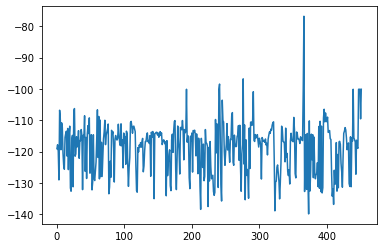

-----------tool_keshid_oomadam_biroon--------
Episode 454 reward: -100.1
454 Average episode reward: -118.70449597028208
[-119.0677961272409, -117.82109943336958, -119.97185042059522, -129.04493754116115, -106.79692437998017, -109.52154627474928, -119.4134536510728, -110.81818449837219, -112.27119873316305, -120.43941081583957, -124.28055715107655, -125.62799552455014, -115.4963088405492, -114.28023085952259, -113.4810453188152, -121.42528764068041, -112.61377966021645, -125.75089372724804, -114.758949489912, -111.8784823816146, -131.61199838972237, -132.65146059060075, -116.21426548718493, -114.81891208341126, -131.24322629310646, -106.96606744091002, -106.26093387706368, -121.46817186340184, -120.73732285054886, -115.2570682357141, -118.5305018094357, -117.19855743254996, -113.31388620230796, -122.12680626933319, -116.48969685874879, -116.51316402035727, -112.95760683807427, -114.88881199102123, -132.15424888894265, -114.79937643208974, -115.32900528060323, -108.55926776577708, -126.

In [107]:
plt.plot(episode_rewards)

In [108]:
np.save('actions.npy', replay.actions)    # .npy extension is added if not given
np.save('current_states.npy', replay.current_states)    # .npy extension is added if not given
np.save('next_states.npy', replay.next_states)    # .npy extension is added if not given
np.save('ends.npy', replay.ends)    # .npy extension is added if not given
np.save('rewards.npy', replay.rewards)    # .npy extension is added if not given
np.save('episode_rewards.npy',np.array(episode_rewards))

In [43]:
np.argwhere(np.isnan(replay.rewards))


array([], shape=(0, 2), dtype=int64)

In [76]:
replay.current_states = replay.current_states[0:-1]

In [80]:
len(replay.rewards)

2431

In [131]:
print(len(replay.actions))    # .npy extension is added if not given
print(len(replay.current_states))    # .npy extension is added if not given
print(len(replay.next_states))    # .npy extension is added if not given
print(len(replay.ends))    # .npy extension is added if not given
print(len(replay.rewards))

0
0
0
0
0


In [ ]:
sac.